## Makemore Part 3: RNN Implementation

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [12]:
# Build vocabulary of charecters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [13]:
# Build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## MLP

In [30]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(135242)
C = torch.randn((vocab_size, n_embd), generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * 0.2
b1 = torch.randn(n_hidden, generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [31]:
# Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
        if i % 10000 == 0:
            print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

      0 /  200000: 3.2903
      0 /  200000: 3.2903
      0 /  200000: 3.2903
      0 /  200000: 3.2903
      0 /  200000: 3.2903
  10000 /  200000: 2.2177
  10000 /  200000: 2.2177
  10000 /  200000: 2.2177
  10000 /  200000: 2.2177
  10000 /  200000: 2.2177
  20000 /  200000: 2.1333
  20000 /  200000: 2.1333
  20000 /  200000: 2.1333
  20000 /  200000: 2.1333
  20000 /  200000: 2.1333
  30000 /  200000: 2.2094
  30000 /  200000: 2.2094
  30000 /  200000: 2.2094
  30000 /  200000: 2.2094
  30000 /  200000: 2.2094
  40000 /  200000: 1.9209
  40000 /  200000: 1.9209
  40000 /  200000: 1.9209
  40000 /  200000: 1.9209
  40000 /  200000: 1.9209
  50000 /  200000: 2.1652
  50000 /  200000: 2.1652
  50000 /  200000: 2.1652
  50000 /  200000: 2.1652
  50000 /  200000: 2.1652
  60000 /  200000: 2.2750
  60000 /  200000: 2.2750
  60000 /  200000: 2.2750
  60000 /  200000: 2.2750
  60000 /  200000: 2.2750
  70000 /  200000: 1.9483
  70000 /  200000: 1.9483
  70000 /  200000: 1.9483
  70000 /  2

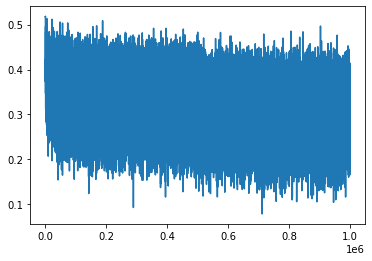

In [32]:
plt.plot(lossi)

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.037980556488037
val 2.1039342880249023


In [29]:
# sample from the model
g = torch.Generator().manual_seed(32131)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

yeshawlen.
lolden.
yachari.
por.
len.
chury.
koelah.
kella.
akianna.
kella.
yun.
zax.
maris.
azia.
aziyah.
jadi.
raymanuyton.
josaynixela.
lay.
dalanoliila.
